In [ ]:
import pickle

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import shapely
from shapely import Point

In [2]:
CITY = "budapest"
STOPS_FILENAME = "stops_gtfs_15min.csv"
DICT_FILENAME = "subgraph_dict_10minute.pkl"

In [3]:
stops = pd.read_csv(f"../data/stops/{CITY}/{STOPS_FILENAME}", engine="pyarrow")
stops["geometry"] = stops.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
stops = gpd.GeoDataFrame(stops, geometry="geometry", crs=4326)
stops.to_crs(23700, inplace=True)
stops.head(3)

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction,clust,max_distance,quant,geometry
0,008951,Béke tér,47.430019,19.215675,None,NaN,008951,2.0,-64.0,11,0.0,1,POINT (662691.105 231796.227)
1,F03807,Szent László utca,47.441814,19.207651,None,NaN,F03807,2.0,30.0,12,0.0,1,POINT (662083.11 233106.253)
2,F03851,Selmecbánya utca,47.438409,19.204790,None,NaN,F03851,2.0,29.0,13,0.0,1,POINT (661868.082 232727.272)


In [24]:
stops.query("stop_name=='501. utca'")

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction,clust,max_distance,quant,geometry
5373,F01720,501. utca,47.485004,19.216899,None,NaN,F01720,1.0,153.0,2078,145.036689,4,POINT (662770.278 237909.321)
5374,F01719,501. utca,47.485004,19.216899,None,NaN,F01720,1.0,-88.0,2078,145.036689,4,POINT (662770.278 237909.321)
5375,F01722,501. utca,47.485004,19.216899,None,NaN,F01720,1.0,85.0,2078,145.036689,4,POINT (662770.278 237909.321)
5381,F03551,501. utca,47.480709,19.219830,None,NaN,F03552,1.0,-83.0,2082,172.958292,2,POINT (662992.208 237432.306)


In [6]:
with open(f"../data/stops/{CITY}/{DICT_FILENAME}", "rb") as fp:
    subgraphs = pickle.load(fp)

In [ ]:
def select_stop(subgraphs: dict, stop_id: str, time_marker: int) -> gpd.GeoDataFrame:
    accessible_stops = list(
        subgraphs.get(f"{stop_id}_network_{time_marker}", nx.Graph())
    )
    return stops[stops["stop_id"].isin(accessible_stops)].copy()


def compute_concaveness_comparision(
    accessible_stops: gpd.GeoDataFrame,
    rs: np.ndarray = np.arange(0, 1.1, 0.2),
) -> gpd.GeoDataFrame:
    records = []
    for r in rs:
        ch = shapely.concave_hull(accessible_stops.union_all(), ratio=r)
        records.append([r, ch])
    result = pd.DataFrame.from_records(records, columns=["concaveness", "geometry"])
    return gpd.GeoDataFrame(result, crs=23700)

In [32]:
s_fovam = compute_concaveness_comparision(select_stop(subgraphs, "F00922", 39))
s_501 = compute_concaveness_comparision(select_stop(subgraphs, "F01720", 39))

0.0,1.85
0.2,1.83
0.4,1.69
0.6,1.63
0.8,1.47
1.0,1.47


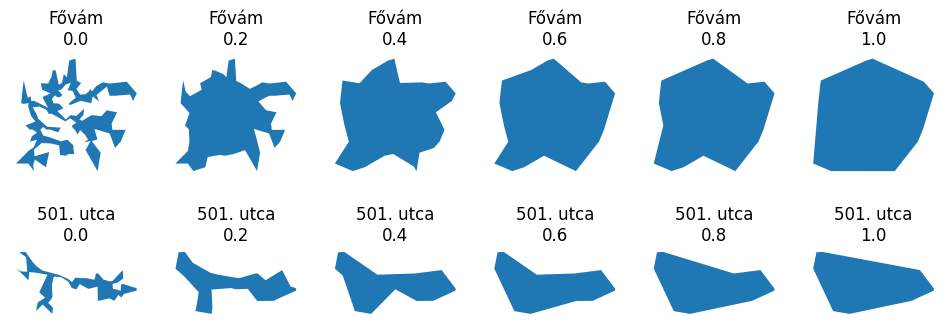

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))
for i, r in enumerate(np.arange(0, 1.1, 0.2)):
    s_fovam.query(f"concaveness == {r}").plot(ax=axs[0][i])
    axs[0][i].axis("off")
    axs[0][i].set_title(f"Fővám\n{r:0.1f}")
    s_501.query(f"concaveness == {r}").plot(ax=axs[1][i])
    axs[1][i].axis("off")
    axs[1][i].set_title(f"501. utca\n{r:0.1f}")

    a_f = s_fovam.query(f"concaveness == {r}").geometry[i].area
    a_5 = s_501.query(f"concaveness == {r}").geometry[i].area
    print(f"{r:0.1f},{a_f / a_5:0.2f}")

In [ ]:
s_fovam_2 = compute_concaveness_comparision(
    select_stop(subgraphs, "F00922", 39), np.arange(0.1, 0.5, 0.05)
)
s_501_2 = compute_concaveness_comparision(
    select_stop(subgraphs, "F01720", 39), np.arange(0.1, 0.5, 0.05)
)

In [71]:
s_fovam_2

,concaveness,geometry
0,0.10,"POLYGON ((648308.253 240049.173, 648354.305 24..."
1,0.15,"POLYGON ((648308.253 240049.173, 648354.305 24..."
2,0.20,"POLYGON ((648308.253 240049.173, 648354.305 24..."
3,0.25,"POLYGON ((648308.253 240049.173, 648354.305 24..."
4,0.30,"POLYGON ((648308.253 240049.173, 648354.305 24..."
5,0.35,"POLYGON ((648308.253 240049.173, 648354.305 24..."
6,0.40,"POLYGON ((648308.253 240049.173, 648354.305 24..."
7,0.45,"POLYGON ((648308.253 240049.173, 648354.305 24..."


In [74]:
0.2

0.2

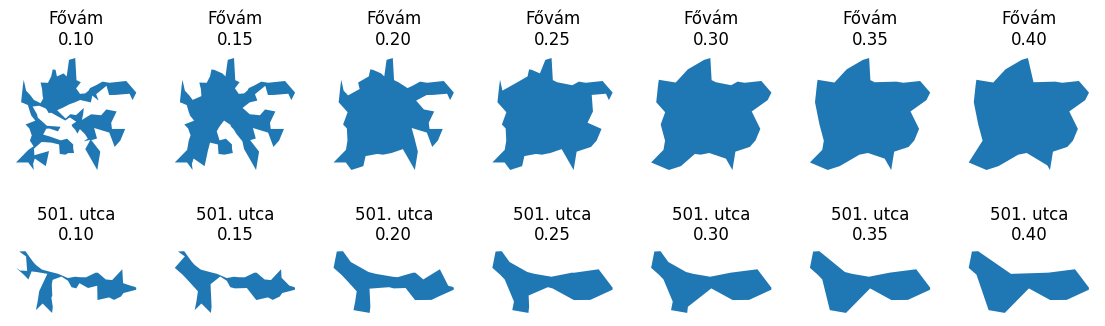

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(14, 4))
for i, r in enumerate(np.arange(0.1, 0.4, 0.05)):
    s_fovam_2[np.isclose(s_fovam_2["concaveness"], r)].plot(ax=axs[0][i])
    axs[0][i].axis("off")
    axs[0][i].set_title(f"Fővám\n{r:0.2f}")
    s_501_2[np.isclose(s_501_2["concaveness"], r)].plot(ax=axs[1][i])
    axs[1][i].axis("off")
    axs[1][i].set_title(f"501. utca\n{r:0.2f}")